In [1]:
import pandas as pd
from data_process.preprocessing import discretization, get_nodes_type, code_categories
from block_learning.train_bn import structure_learning, parameter_learning
from block_learning.partial_bn_train import connect_partial_bn, hierarchical_train, direct_connect, direct_train
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from block_learning.save_bn import save_structure, save_params
from block_learning.read_bn import read_structure, read_params
from block_learning.sampling import generate_synthetics, get_probability
from libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import visualizer, draw_comparative_hist
import networkx as nx

In [2]:
data = pd.read_csv('data/final_dataset_no_posts_info.csv')
data.head(10)

,age,age_hidden,has_high_education,is_closed,len_of_about,len_of_status,number_of_activities,number_of_books,number_of_followers,number_of_friends,...,driver,has_pets,cash_usage,gulyaka,zhavoronok,sum_act,top1,top2,top3,top4
0,34,0.0,1,0,14,16,1,1,720,911,...,0,0,0,1,0,1,Gifts & holidays,Music,History & politics,Purchase & sale
1,0,1.0,0,0,0,0,0,0,87638,687,...,1,0,0,1,0,2,Gifts & holidays,History & politics,Love & relation,Music
2,37,0.0,0,0,0,2,0,0,0,24,...,0,1,0,0,0,1,Purchase & sale,Gifts & holidays,Cooking,Love & relation
3,39,0.0,1,0,0,11,1,1,317,291,...,0,0,0,1,0,2,History & politics,Gifts & holidays,Love & relation,Job & money
4,34,0.0,0,0,0,11,0,0,328,413,...,0,0,0,1,0,1,Gifts & holidays,Music,History & politics,Love & relation
5,36,0.0,0,0,0,0,0,0,474,175,...,1,0,0,0,0,1,Gifts & holidays,History & politics,Love & relation,Fitness & cosmetology
6,0,1.0,0,0,0,3,0,0,7458,982,...,0,1,0,1,0,2,Gifts & holidays,Music,History & politics,Purchase & sale
7,35,0.0,0,0,0,0,0,0,2659,279,...,1,0,0,0,0,1,Gifts & holidays,History & politics,Music,Purchase & sale
8,41,0.0,0,0,0,0,0,0,651,134,...,1,0,0,0,0,1,Gifts & holidays,Love & relation,History & politics,Purchase & sale
9,34,0.0,1,0,0,4,1,4,1522,177,...,1,0,0,0,0,2,Gifts & holidays,Love & relation,History & politics,Cooking


In [3]:
data.shape

(51478, 49)

In [4]:
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [5]:
data = data.loc[(data['age'] != 0) & (data['age'] < 60)]

In [6]:
data.reset_index(inplace=True, drop=True)

In [7]:
data = data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives','len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies','top1','top2','top3','top4', 'nodes',	'betweenness_centrality',	'density',	'eigenvector_centrality',	'degree_assortativity_coefficient', 'number_of_followers', 'max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']] #'posts_count',	'posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']]

In [8]:
discrete_data = discretization(data, 'kmeans', bins= 5, columns=['betweenness_centrality',	'density',	'eigenvector_centrality',	'degree_assortativity_coefficient','max_tr',	'mean_tr'])#, 'posts_per_month', 'repost_ratio'])

In [9]:
new_data = code_categories(discrete_data, ['top1', 'top2', 'top3', 'top4'])

In [10]:
module1 = new_data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']]
module2 = new_data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']]
module3 = new_data[['top1', 'top2', 'top3', 'top4']]
module4 = new_data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'number_of_followers', 'density', 'degree_assortativity_coefficient']]
module5 = new_data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']]
#module6 = new_data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']]

In [11]:
node_type1 = get_nodes_type(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']])
node_type1

{'age': 'disc',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation_status': 'disc',
 'number_of_relatives': 'disc'}

In [12]:
node_type2 = get_nodes_type(data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']])
node_type2

{'len_of_about': 'disc',
 'number_of_activities': 'disc',
 'number_of_books': 'disc',
 'number_of_interests': 'disc',
 'number_of_movies': 'disc'}

In [13]:
node_type3 = get_nodes_type(data[['top1', 'top2', 'top3', 'top4']])
node_type3

{'top1': 'disc', 'top2': 'disc', 'top3': 'disc', 'top4': 'disc'}

In [14]:
node_type4 = get_nodes_type(data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'number_of_followers', 'density', 'degree_assortativity_coefficient']])
node_type4

{'nodes': 'disc',
 'betweenness_centrality': 'cont',
 'eigenvector_centrality': 'cont',
 'number_of_followers': 'disc',
 'density': 'cont',
 'degree_assortativity_coefficient': 'cont'}

In [15]:
node_type5 = get_nodes_type(data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']])
node_type5

{'max_tr': 'cont',
 'mean_tr': 'cont',
 'parent': 'disc',
 'driver': 'disc',
 'has_pets': 'disc',
 'cash_usage': 'disc'}

In [16]:
# node_type6 = get_nodes_type(data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']])
# node_type6

In [17]:
start = time.time()
bn1 = structure_learning(module1, 'MI', node_type1)

c:\Users\irina\Documents\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\pyBN\utils\independence_tests.py:37: RuntimeWarning: divide by zero encountered in log
  MI = -1 * np.sum( Px * np.log( Px ) )
c:\Users\irina\Documents\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\pyBN\utils\independence_tests.py:37: RuntimeWarning: invalid value encountered in multiply
  MI = -1 * np.sum( Px * np.log( Px ) )


In [18]:
bn1

{'V': ['age',
  'sex',
  'has_high_education',
  'relation_status',
  'number_of_relatives'],
 'E': [['number_of_relatives', 'age'],
  ['has_high_education', 'sex'],
  ['number_of_relatives', 'has_high_education'],
  ['age', 'has_high_education'],
  ['number_of_relatives', 'relation_status'],
  ['sex', 'relation_status']]}

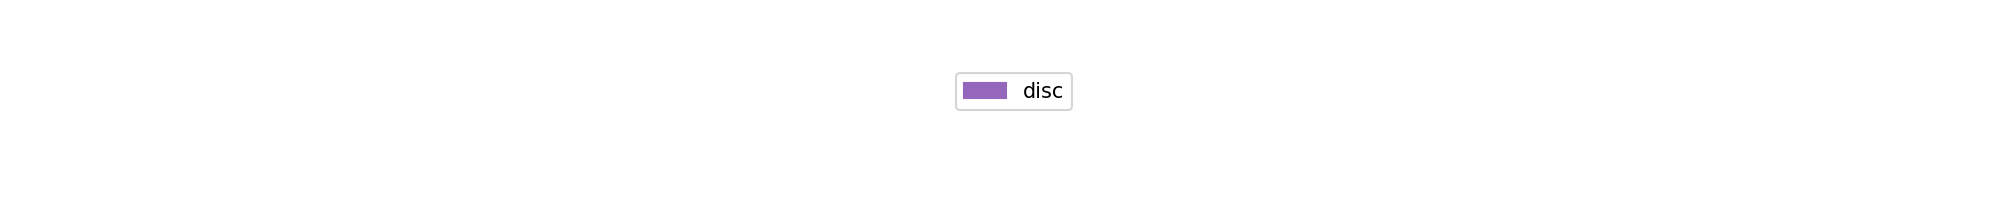

In [19]:
visualizer(bn1, node_type1, 'module1')

In [20]:
param1 = parameter_learning(data[['age',	'sex',	'has_high_education',	'relation_status',	'number_of_relatives']], node_type1, bn1)

In [21]:
save_structure(bn1, 'skel1')
skel1 = read_structure('skel1')
save_params(param1, 'params1')
params1 = read_params('params1')
hybn1 = HyBayesianNetwork(skel1, params1)

In [22]:
end = time.time()
print(end - start)

16.02945852279663


In [23]:
bn2 = structure_learning(module2, 'K2', node_type2)

  0%|          | 4/1000000 [00:00<38:03:54,  7.30it/s]


In [24]:
bn2

{'V': ['len_of_about',
  'number_of_activities',
  'number_of_books',
  'number_of_interests',
  'number_of_movies'],
 'E': [['number_of_activities', 'len_of_about'],
  ['number_of_books', 'number_of_interests'],
  ['number_of_interests', 'number_of_activities'],
  ['number_of_movies', 'number_of_books']]}

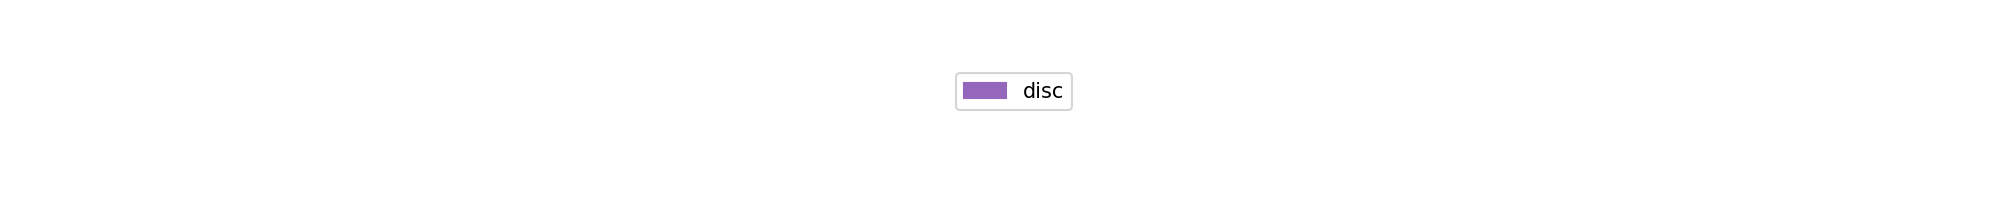

In [25]:
visualizer(bn2, node_type2, 'module2')

In [26]:
param2 = parameter_learning(data[['len_of_about',	'number_of_activities',	'number_of_books',	'number_of_interests',	'number_of_movies']], node_type2, bn2)

In [27]:
save_structure(bn2, 'skel2')
skel2 = read_structure('skel2')
save_params(param2, 'params2')
params2 = read_params('params2')
hybn2 = HyBayesianNetwork(skel2, params2)


In [28]:
end = time.time()
print(end - start)

17.619163036346436


In [29]:
bn3 = structure_learning(module3, 'K2', node_type3)
bn3

  0%|          | 6/1000000 [00:00<11:45:43, 23.62it/s]


{'V': ['top1', 'top2', 'top3', 'top4'],
 'E': [['top1', 'top2'],
  ['top1', 'top4'],
  ['top1', 'top3'],
  ['top2', 'top4'],
  ['top2', 'top3'],
  ['top3', 'top4']]}

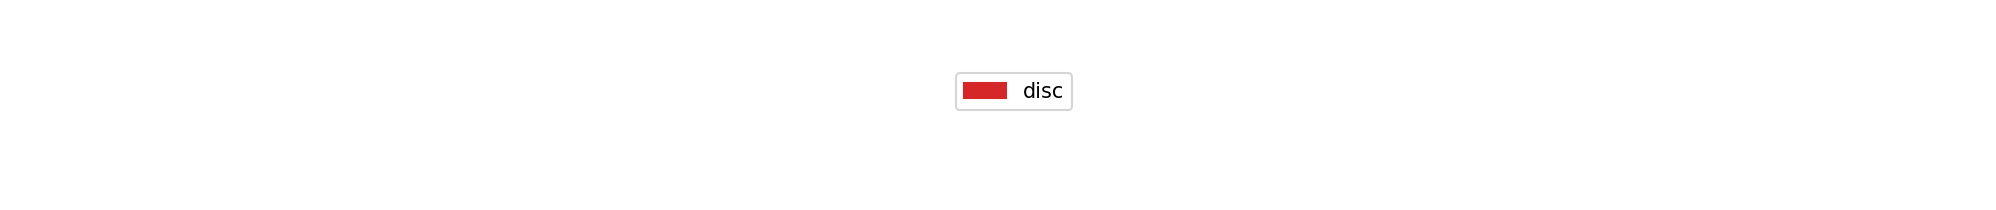

In [30]:
visualizer(bn3, node_type3, 'module3')

In [31]:
param3 = parameter_learning(data[['top1', 'top2', 'top3', 'top4']], node_type3, bn3)

In [32]:
save_structure(bn3, 'skel3')
skel3 = read_structure('skel3')
save_params(param3, 'params3')
params3 = read_params('params3')
hybn3 = HyBayesianNetwork(skel3, params3)

In [33]:
bn4 = structure_learning(module4, 'BDeu', node_type4)
bn4

  0%|          | 7/1000000 [00:08<352:33:32,  1.27s/it]

{'V': ['nodes',
  'betweenness_centrality',
  'eigenvector_centrality',
  'number_of_followers',
  'density',
  'degree_assortativity_coefficient'],
 'E': [['nodes', 'degree_assortativity_coefficient'],
  ['nodes', 'density'],
  ['betweenness_centrality', 'eigenvector_centrality'],
  ['density', 'betweenness_centrality'],
  ['density', 'degree_assortativity_coefficient'],
  ['degree_assortativity_coefficient', 'eigenvector_centrality'],
  ['degree_assortativity_coefficient', 'betweenness_centrality']]}

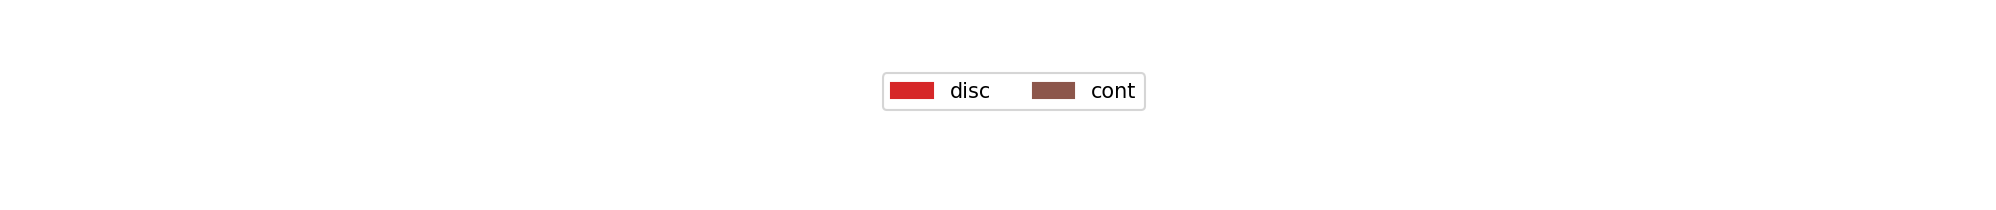

In [34]:
visualizer(bn4, node_type4, 'module4')

In [35]:
param4 = parameter_learning(data[['nodes',	'betweenness_centrality',	'eigenvector_centrality', 'number_of_followers', 'density', 'degree_assortativity_coefficient']], node_type4, bn4)

In [36]:
save_structure(bn4, 'skel4')
skel4 = read_structure('skel4')
save_params(param4, 'params4')
params4 = read_params('params4')
hybn4 = HyBayesianNetwork(skel4, params4)

In [37]:
bn5 = structure_learning(module5, 'K2', node_type5)


  0%|          | 7/1000000 [00:00<21:16:30, 13.06it/s]


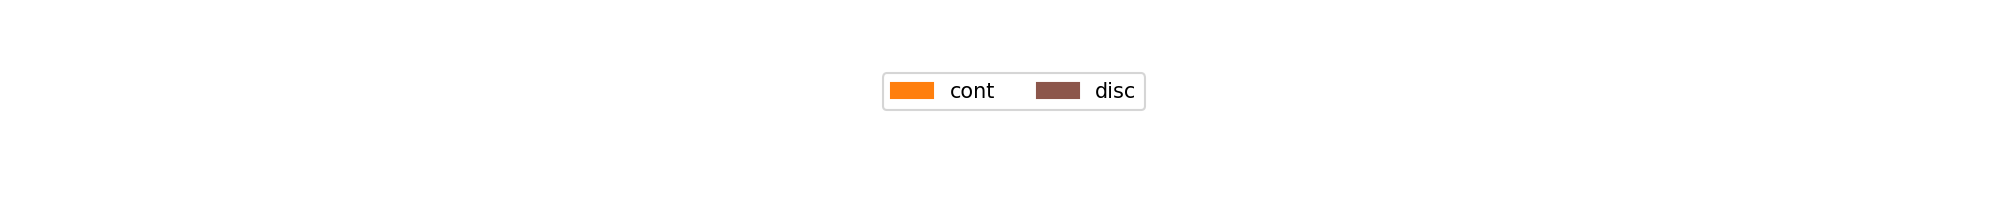

In [38]:
visualizer(bn5, node_type5, 'module5')

In [39]:
param5 = parameter_learning(data[['max_tr',	'mean_tr', 'parent',	'driver',	'has_pets',	'cash_usage']], node_type5, bn5)

In [40]:
save_structure(bn5, 'skel5')
skel5 = read_structure('skel5')
save_params(param5, 'params5')
params5 = read_params('params5')
hybn5 = HyBayesianNetwork(skel5, params5)

In [41]:
# bn6 = structure_learning(module6, 'MI', node_type6)
# bn6

In [42]:
#param6 = parameter_learning(data[['posts_per_month',	'likes_per_post',	'views_per_post',	'repost_ratio']], node_type6, bn6)

In [43]:
# save_structure(bn6, 'skel6')
# skel6 = read_structure('skel6')
# save_params(param6, 'params6')
# params6 = read_params('params6')
# hybn6 = HyBayesianNetwork(skel6, params6)

In [44]:
node_type_final = {**node_type1, **node_type2, **node_type3, **node_type4, **node_type5}

In [45]:
node_type_final

{'age': 'disc',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation_status': 'disc',
 'number_of_relatives': 'disc',
 'len_of_about': 'disc',
 'number_of_activities': 'disc',
 'number_of_books': 'disc',
 'number_of_interests': 'disc',
 'number_of_movies': 'disc',
 'top1': 'disc',
 'top2': 'disc',
 'top3': 'disc',
 'top4': 'disc',
 'nodes': 'disc',
 'betweenness_centrality': 'cont',
 'eigenvector_centrality': 'cont',
 'number_of_followers': 'disc',
 'density': 'cont',
 'degree_assortativity_coefficient': 'cont',
 'max_tr': 'cont',
 'mean_tr': 'cont',
 'parent': 'disc',
 'driver': 'disc',
 'has_pets': 'disc',
 'cash_usage': 'disc'}

In [46]:
hybn_connect = direct_connect([hybn1,hybn2, hybn3, hybn4, hybn5],new_data, node_type_final)



  0%|          | 17/1000000 [01:12<1181:43:35,  4.25s/it]

In [47]:
hybn_connect

['0 1', '0 2', '0 3', '0 4', '2 4']

In [48]:
hybns = [hybn1,hybn2, hybn3, hybn4, hybn5]

In [49]:
hybn_final = direct_train(hybns, data, hybn_connect)

c:\Users\irina\Documents\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\block_learning\partial_bn_train.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[name] = latent_sample
c:\Users\irina\Documents\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\block_learning\partial_bn_train.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[name] = latent_sample
c:\Users\irina\Documents\Synthetic avatar\Synthetic_scripts\BN-based synthetic data\block_learning\partial_bn_train.py:47: SettingWithCopyWarning: 
A valu

In [50]:
final_struct = dict()
final_struct['V'] = hybn_final.V
final_struct['E'] = hybn_final.E

In [51]:
final_struct['V'] 

['number_of_relatives',
 'age',
 'has_high_education',
 'sex',
 'relation_status',
 'L 0_2',
 'top1',
 'top2',
 'top3',
 'top4',
 'L 2_4',
 'L 0_4',
 'cash_usage',
 'parent',
 'mean_tr',
 'driver',
 'has_pets',
 'max_tr',
 'L 0_1',
 'number_of_movies',
 'number_of_books',
 'number_of_interests',
 'number_of_activities',
 'len_of_about',
 'L 0_3',
 'number_of_followers',
 'nodes',
 'density',
 'degree_assortativity_coefficient',
 'betweenness_centrality',
 'eigenvector_centrality']

In [52]:
final_struct['E']

[['cash_usage', 'driver'],
 ['number_of_interests', 'number_of_activities'],
 ['number_of_relatives', 'age'],
 ['top1', 'top4'],
 ['sex', 'relation_status'],
 ['relation_status', 'L 0_2'],
 ['relation_status', 'L 0_4'],
 ['parent', 'mean_tr'],
 ['top2', 'top3'],
 ['nodes', 'density'],
 ['driver', 'has_pets'],
 ['nodes', 'degree_assortativity_coefficient'],
 ['number_of_activities', 'len_of_about'],
 ['parent', 'has_pets'],
 ['relation_status', 'L 0_1'],
 ['cash_usage', 'parent'],
 ['density', 'betweenness_centrality'],
 ['density', 'degree_assortativity_coefficient'],
 ['top3', 'top4'],
 ['age', 'has_high_education'],
 ['L 0_4', 'cash_usage'],
 ['parent', 'driver'],
 ['number_of_relatives', 'relation_status'],
 ['top1', 'top3'],
 ['L 0_3', 'number_of_followers'],
 ['betweenness_centrality', 'eigenvector_centrality'],
 ['degree_assortativity_coefficient', 'eigenvector_centrality'],
 ['has_pets', 'max_tr'],
 ['L 0_3', 'nodes'],
 ['mean_tr', 'max_tr'],
 ['relation_status', 'L 0_3'],
 ['nu

In [53]:
node_type_final['L 0_1'] = 'disc'
node_type_final['L 0_3'] = 'disc'
node_type_final['L 0_4'] = 'disc'
node_type_final['L 2_0'] = 'disc'
node_type_final['L 2_4'] = 'disc'

In [54]:
node_type_final

{'age': 'disc',
 'sex': 'disc',
 'has_high_education': 'disc',
 'relation_status': 'disc',
 'number_of_relatives': 'disc',
 'len_of_about': 'disc',
 'number_of_activities': 'disc',
 'number_of_books': 'disc',
 'number_of_interests': 'disc',
 'number_of_movies': 'disc',
 'top1': 'disc',
 'top2': 'disc',
 'top3': 'disc',
 'top4': 'disc',
 'nodes': 'disc',
 'betweenness_centrality': 'cont',
 'eigenvector_centrality': 'cont',
 'number_of_followers': 'disc',
 'density': 'cont',
 'degree_assortativity_coefficient': 'cont',
 'max_tr': 'cont',
 'mean_tr': 'cont',
 'parent': 'disc',
 'driver': 'disc',
 'has_pets': 'disc',
 'cash_usage': 'disc',
 'L 0_1': 'disc',
 'L 0_3': 'disc',
 'L 0_4': 'disc',
 'L 2_0': 'disc',
 'L 2_4': 'disc'}

In [55]:
sample = generate_synthetics(hybn_final, 50000)

In [56]:
sample

,L 0_1,L 0_2,L 0_3,L 0_4,L 2_4,age,betweenness_centrality,cash_usage,degree_assortativity_coefficient,density,...,number_of_interests,number_of_movies,number_of_relatives,parent,relation_status,sex,top1,top2,top3,top4
0,1,2,1,1,1,52,0.743841,0,-0.200081,0.158517,...,1,1,0,0,0,1,History & politics,Gifts & holidays,Love & relation,Job & money
1,1,2,0,0,1,31,0.780639,0,-0.231285,0.038466,...,1,1,0,0,0,2,Cooking,Gifts & holidays,Love & relation,History & politics
2,0,1,2,2,1,47,1.038885,0,-0.303517,0.125923,...,0,0,1,0,4,1,History & politics,Job & money,Gifts & holidays,Fitness & cosmetology
3,0,0,0,0,1,40,0.855726,0,-0.188805,0.021578,...,0,0,0,0,0,2,Cooking,Love & relation,Fitness & cosmetology,Gifts & holidays
4,0,0,0,0,0,44,0.718048,0,-0.183869,0.052351,...,0,0,0,0,0,2,Purchase & sale,Gifts & holidays,Fitness & cosmetology,Cooking
5,1,0,1,2,2,35,0.459603,0,-0.175392,0.078856,...,0,0,0,0,0,2,Love & relation,Gifts & holidays,Purchase & sale,Music
6,2,1,0,2,2,33,0.897287,0,-0.022957,0.058225,...,0,0,5,0,4,2,Love & relation,Purchase & sale,Music,History & politics
7,1,1,1,0,0,32,1.145246,0,-0.222803,0.059559,...,0,0,0,1,4,2,Gifts & holidays,Purchase & sale,Fitness & cosmetology,Job & money
8,1,0,1,1,0,38,1.135423,0,-0.171513,0.053806,...,0,0,0,0,0,1,Gifts & holidays,Love & relation,History & politics,Job & money
9,0,1,1,0,1,54,0.869538,0,-0.385787,0.072470,...,1,1,7,0,4,2,Gifts & holidays,Cooking,Love & relation,Music
